<br>

<h1 style="color: #001a79;">Anomaly Detection using Keras</h1>

<hr style="border-top: 1px solid #001a79;" />

Offical documentation: https://keras.io/examples/timeseries/timeseries_anomaly_detection/

<br>

<h2 style="color: #001a79;">Introduction</h2>

<hr style="border-top: 1px solid #001a79;" />


This notebook is a re-creation of the timeseries anomaly detection using an Autoencoder.


The goal of this notebook is to display how we can reconstruct convilutional autoencoder model to detect anomalies using a timeseries. In other words, I will use keras to build and train a model which will hopefully detect anomolies in the testing data.


The following code was adapted from the official documentation cited above and also from my lectures notebook which can be found here: https://github.com/ianmcloughlin/2223-S1-machine-learn-stats/blob/main/notebooks/05-evaluation.ipynb



<br>

<h2 style="color: #001a79;">Importing Modules</h2>

<hr style="border-top: 1px solid #001a79;" />

In [1]:
# For numerical arrrays.
import numpy as np

# Dealing with dataframes. 
import pandas as pd

# For neural networks.
import tensorflow.keras as keras

# For data visualisation. 
from matplotlib import pyplot as plt

<h3 style="color: #001a79;">TensorFlow</h3>

Tensorflow is a platform widely using in machine learning and statistics. It purpose is to aid with data automation, model tracking, performance monitoring and model retraining. 

Offical documentation can be found here: https://www.tensorflow.org/learn

<h3 style="color: #001a79;">Keras</h3>

Keras is a deep learning API which runs on top of TensorFlow. It's purpose is to provide a simple and flexible way of experimenting with ideas and producing fast results. It is an important library for completeing research. 


Offical documentation can be accessed here: https://keras.io/

<br>

<h2 style="color: #001a79;">Loading the data</h2>

<hr style="border-top: 1px solid #001a79;" />

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

For this experiment the Numenta Anomaly Benchmark(NAB) dataset is used which can be found [here](https://www.kaggle.com/datasets/boltzmannbrain/nab). This is an open source dataset and is an artifical timeseries where the data is ordered, timestamped and has single-valued metrics. It contains labelled real-world time-series data which is what makes it so simple and effective to use. 

There are two csv files associated with this dataset which we will use for training and testing of data. The next code cell sets these datasets up with their variable names. 

`artificialNoAnomaly/art_daily_small_noise.csv` contains a timestamp and some values. This csv contains artifical data which does not contain any anomalies. This dataset will be used for training the model. 

`artificialWithAnomaly/art_daily_jumpsup.csv`also contains timestamps and values. The difference is that this file contains anomalies. This will be used for testing the model. 


In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly for training.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly for testing
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

We can have a look at the urls in our web-browser. Follow the http links provided from the following two cells. Here you will see the raw data for these CSVs.

In [3]:
# http for data file without anomaly for training.
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
# http for data file with anomaly for testing. 
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

<h3 style="color: #001a79;">Timeseries data without anomalies</h3>


Let's take a look at the data without anomalies using pandas to read in the csv file. 

In [5]:
# Small noise dataframe (no anomaly) for training.
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

Pandas has a lot of functionality when dealing with dataframes. I will use some of these functions to have a look at the data and ensure everything is in order. 

Offical pandas documentation can be found here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [6]:
# describe returns descriptive analysis of df. 
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [7]:
# head returns the first 5 rows of a df. 
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [8]:
# iloc returns data at idex specified. 
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

This is interesting development. Here, iloc has shown us the first row of data. What's curious is that the value appears to have been rounded. If we look at the raw csv data from the http links, we can see the first value differs from the value produced iusing pandas iloc. 

Here is a screensnip of the small noise http link showing the raw csv data. 

![smallnoise](images/small_noise.jpg)

<br>

The first value is 18.324918539200002 whereas the pandas dataframe has it as 18.324919

Let's look at the first row using different methods:

In [9]:
# Let's look at row 1 value.
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# Let's look at row 1 value 1.
df_small_noise.iloc[0].values[0]

18.3249185392

In [11]:
# Gives the closest value but still rounded
df_small_noise.iloc[0].values[0] * 10e12

183249185392000.0

After a bit of digging I discovered a blogpost on stackoverflow which can be found here: https://stackoverflow.com/questions/43227058/why-is-python-pandas-dataframe-rounding-my-values


Other users ran into similar issues and one response suggested it is the percision setting of pandas. When I researched the pandas documentation I found my answer here: https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#frequently-used-options


This suggests that pandas is not changing the actual value but just the way in which the value is displayed. Therefore, I have concluded that this is just a simple display issue which will not affect the data or the results when processing the data. 

<h3 style="color: #001a79;">Plotting timeseries data without anomalies</h3>

Let's take a look at our dataframe without anomalies from the small noise csv. 

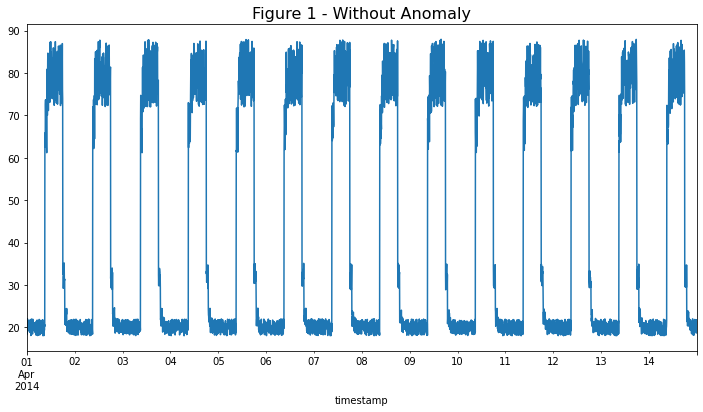

In [12]:
# Plot without anomalies. 
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Figure 1 - Without Anomaly", size=16)

# ax=ax means it will create its own seet of axes . 
df_small_noise.plot(legend=False, ax=ax);

The data in Figure 1 will be used for training the model. 

<h3 style="color: #001a79;">Timeseries data with anomalies</h3>


Let's take a look at the data with anomalies using pandas to read in the csv file. 

In [13]:
# jumpsup dataframe (eith anomaly) for testing.
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [14]:
# describe returns descriptive analysis.
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [15]:
# Returns first 5 rows. 
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [16]:
# iloc returns specific row
df_daily_jumpsup.iloc[0]['value']

19.761251903

We can see the same thing has happened when displaying the jumpsup data in a pandas dataframe. The value of the first row is different to the raw value. However, we now understand this only affects the displaying of the dataset when using pandas. 


![jumpsup](images/jumpsup.jpg)

In [17]:
# shape returns the dimensionality of df. 
df_daily_jumpsup.shape

(4032, 1)

<h3 style="color: #001a79;">Plotting timeseries data with anomalies</h3>

Let's plot the dataframe with anomaly data from the jumpsup csv. 

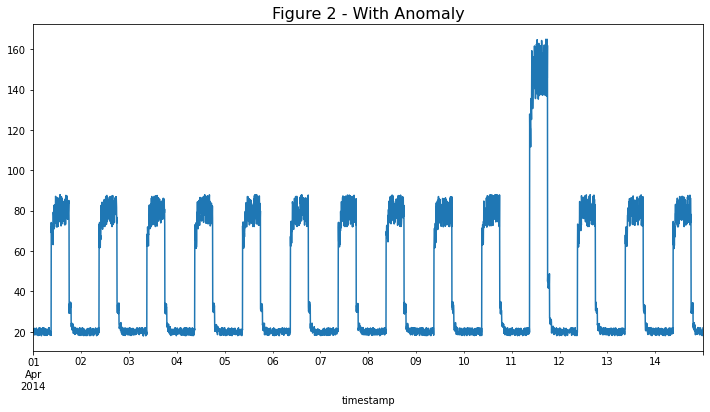

In [18]:
# Plot with anomalies. 
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Figure 2 - With Anomaly", size=16)

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

We can see here in Figure 2 that there is a jump in the data and the range of the y-axis differes from Figure 1 suggesting an anomaly is present. This data will be used for testing the model. 

<br>

<h2 style="color: #001a79;">Preprocessing</h2>

<hr style="border-top: 1px solid #001a79;" />

The idea around preprocessing is to prepare data before it goes into the neural network. This is done by creating a datafrane with trained data. And then by creating a window sequence for that trained data. 

<h3 style="color: #001a79;">Training the model</h3>

This is done using the data from the small noise dataframe which we saw back in Figure 1.

First we get the mean and standard deviation of the values. Then we subtract the mean of the values from each of the values and divide by the standard deviation. 

This gives us our trained data. 

In [19]:
# Get mean of df without anomaly.
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [20]:
# Get std of df without anomaly.
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [21]:
# Subtract mean and divide by std for training values. 
df_train_vals = (df_small_noise - train_mean) / train_std

In [22]:
# Have a look at training values.
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


We can create new columns for dataframes by simply assigning values to it. The next cell assigns values for the mean and standard deviation which we can see in the dataframe below. 

In [23]:
# New column for mean. 
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()

# New column for std. 
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [24]:
# See amended dataframe.
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [25]:
# Have a look at means for columns.
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [26]:
# Have a look at std of columns. std of value and less mean are the same. 
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

<h3 style="color: #001a79;">Plotting the trained data</h3>

Let's have a look at the trained data. 

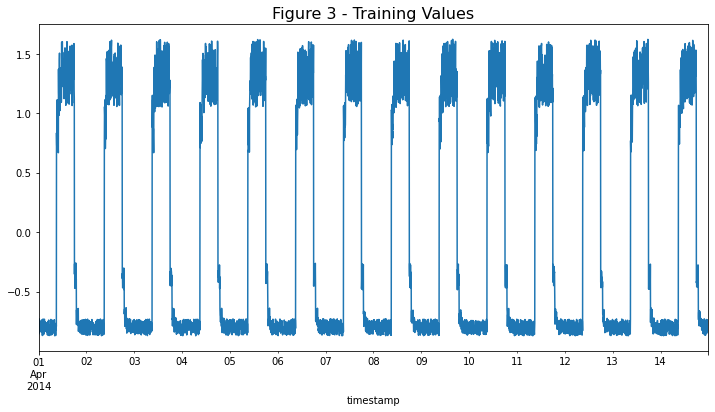

In [27]:
# Plotting the trained data
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Figure 3 - Training Values", size=16)

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

We can see from Figure 3 that training the data has changed the results if you compare it to Figure 1 before it was trained. It's basically just scaled down the y-axis. 


The reason for this is that the standard deviation shoud always be in or around 1. Really, this figure should be centered around zero with equal distance between the high and low values. We can see here that the high values are around 1.5 whereas the low ones are at about -0.8. This suggests there are more low values than high ones because the high ones are further away from zero. 

In [28]:
# Look at shape of the trained model. 
df_train_vals.shape

(4032, 1)

<h3 style="color: #001a79;">Creating a Window Sequence</h3>

What is the purpose of a window?

I found a good blog post which helps explain the meaning behind a sliding window in anomaly detection. It can be found here: https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a


Basically, a sliding window is used across an array of values. Each window is the actual input for the neural network. And it will check the mean and standard deviation in each window. It is like a sliding door as it moves one place to the right for each window. 

<h4 style="color: #001a79;">Example of how a window sequence works</h4>

In [29]:
# EXAMPLE OF HOW A WINDOW FUNCTION WILL WORK. 

# Dummy window list.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]

# Example window size.
win_size = 3

# Length of L.
len(L)

12

In [30]:
#Subtract number of windows from length of L.
len(L) - (win_size - 1)

10

In [31]:
# Remove brackets and gives the same response.
len(L) - win_size + 1

10

In [32]:
# Print the windows from i up to i plus the window size. 
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [33]:
# For accumulating the windows.
wins = []

# Generate the windows and add to list.
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

Numpy has a useful method called stack. Basically, it takes in a sequence for example the wins list. And it returns these wins in a single numpy array. 

Offical documentation can be found here: https://numpy.org/doc/stable/reference/generated/numpy.stack.html

In [34]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

<h3 style="color: #001a79;">Generating the window sequence</h3>

Now that we understand how to create a sliding window and what it is used for we need to generate one for the training model. 

In [35]:
# Setting the window size for trained model. 
window_size = 288

The function below takes the values and the window size. Loops through all the possible windows for those values, appends them to a list and converts that list into a numpy array. 

In [36]:
# Function to create the window.
def windows(vals, N=window_size):
  # Start with an empty list.
  L = []
  # loop through all possible windows
  for i in range(len(vals) - N + 1):
    # Append window to list.
    L.append(vals[i:i+N])
  # Stack them in np array. 
  return np.stack(L)

In [37]:
# Create the window sequence for training values. 
x_train = windows(df_train_vals)

Now that the window sequences have been created lets compare the first and last values of the windows to the first and last values of the training model. 

In [38]:
# Shows first and last values of the windows array.  
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [39]:
# Shows frist and last values of the training values. 
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

So we can see they're pretty much the same which is good. Pandas has rounded the values again but as already stated this won't affect the results. 

In [40]:
# Check the shape
x_train.shape

(3745, 288, 1)

In [41]:
# Pull out values of the training model. 
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

Numpy has another useful method called flatten. This takes a 2D arrray and flattens it into one dimension. The reason we are flattening this is so we can use it more efficently in the neural network. 

Offical documentation can be found here: https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html

In [42]:
# FLATTEN GETS RID OF ALL INNER ARRAYS AND FLATTENS THEM OUT
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

<h3 style="color: #001a79;">Plotting the Window Sequence</h3>

See Figure 4 below which is a plot of a window sequence on top of the training values. The blue line is the training values and the orange is a window. 

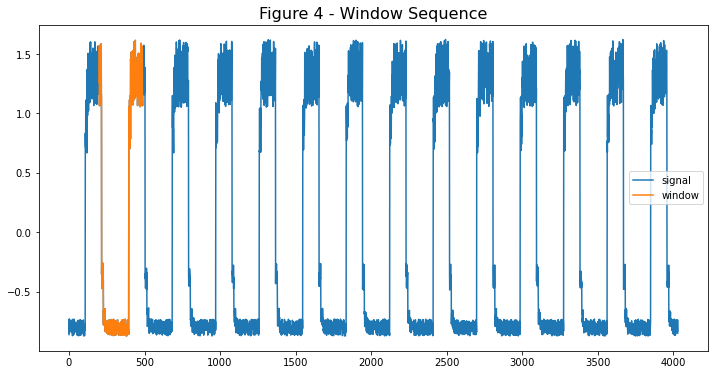

In [43]:
# Assign window number
window_no = 200

# Plotting the window
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Figure 4 - Window Sequence", size=16)

# Pull out training values for y
y = df_train_vals['value'].values

# Create an array
ax.plot(np.arange(y.shape[0]), y, label='signal')

# Assign the first window. 
w = x_train[window_no].flatten()

# PLot the first windw on top the the training values.
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

<br>

<h2 style="color: #001a79;">Neural Network</h2>

<hr style="border-top: 1px solid #001a79;" />

A neural network is like a basket of neurons. These neurons take in inputs and give outputs. The neurons in the network are all connected. An example of a neural network is Google's search algorithm. A search is input in and google returns an output of results based on that input. 

Check out this nice blog I found which has some simple and clear explainations on neural networks: https://www.ibm.com/cloud/learn/neural-networks

In [44]:
# Check out the shape of the window sequence
x_train.shape

(3745, 288, 1)

<h3 style="color: #001a79;">Layers</h3>

The keras documentation states that layers are like building blocks for neural networks. In other words, each layer contributes to the foundation of the neural network. 


Let's explore the layers used in the code cell below:


- `Input` - the input layer decides the shape of the network. In the cell below I have passed in the trained input shape and the trained output shape. It is possible to only select an inpupt shape, however, the idea of the training model is to train the input and output values so that when an anomaly occures it can be detected. 



- `Conv1D` - the 1D convolution layer is important as it combines two signals to form a third one. In other words, the relationship between the input and output is expressed through this third signal. This is a good blogpost which explains the meaning behind convolution: https://www.tutorialspoint.com/what-is-convolution-in-signals-and-systems



- `Dropout` - the dropout layer is used to input units to 0 with the specified rate. The idea of this is to prevent overfitting. In other words, so we don't have the results produced to return the exact same data. 



- `Conv1DTranspose` - the 1D convolution transpose layer does what the basic 1D convolution layer does but with a modified input feature map. What this means is that it is taking in the input signal, transforming it a bit and combining it with the output signal and gives a thrid signal. 



Offical documentation for Keras layers can be found here: https://keras.io/api/layers/#:~:text=Layers%20are%20the%20basic%20building,variables%20(the%20layer%27s%20weights).

In [45]:
# Building block for neural network.
layers = [
  # Determine shape of neural network.
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # To combine 1D signals.
  keras.layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # To prevent overfitting.
  keras.layers.Dropout(rate=0.2),
  # To combine 1D signals again.
  keras.layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # To combine 1D signals while transforming input signal
  keras.layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #To prevent overfitting again.
  keras.layers.Dropout(rate=0.2),
  # To combine 1D signals while transforming input signal again.
  keras.layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # To combine 1D signals while transforming input signal again.
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

<h4 style="color: #001a79;">Sequential</h4>

In the code cell below the `Sequential` method is used. This stipulates that the way the layers are listed above is the exact order in which the blocks will be built. We can see that some layers are used multiple times. This is part of the design of the neural network and is intended to be layered in this order. 

In [46]:
# To build the network in the exact order of layers. 
model = keras.Sequential(layers)

<h4 style="color: #001a79;">Adam Optimization</h4>

Adam is a class of the optimizer method within Keras. It is considered to be one of the best optimizers. The official Keras documentation states:


> Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.


Basically, the stochastic gradient decent is an iterative method which maintains a single learning rate. This rate does not change for the duration of the test. The Adam is used here as it is known for achieving good, results fast. The idea behind an optimizer is to change some attributes of the model to smooth out any bumps to reduce the losses so that we can help get faster results.


There is a nice blog which introduces the idea of Adam optimization. It can be found here: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [47]:
# Optimization for stochastic gradient descent.
optimizer = keras.optimizers.Adam(learning_rate=0.001)

<h4 style="color: #001a79;">Losses</h4>

I mentioned this idea of losses previously. The loss function is used as part of the optimization process. This is done because the error for the current state of the training model must be estimated on a continuous basis. To allow for this error we introduce a loss function. This produces an estimate so the state can be updated which will reduce the loss on the next window evaluation. 

We introduce our loss through the compile method. This means we are compliling our model using the mse loss function. 

In [48]:
# complile it - LOADS OUT THERE ON LOSS MSE
model.compile(optimizer=optimizer, loss="mse")

<h4 style="color: #001a79;">Mean Squared Error (MSE)</h4>

MSE is one of the loss function classes available in Keras. The official documentation states that it calculates the mean of squares of errors between labels and predictions. 


We have established that we are using a loss function to reduce the loss for the next evaluation but why MSE? 


MSE is considered to be the simplest loss function available. There is a good blog which explains it quite well. The MSE takes the difference between the model's predictions and the actual data and squares it. Next you get the average across the whole dataset. 

The blog can be found here: https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3

<h4 style="color: #001a79;">Summary</h4>

This is a useful method which returns a summary of each layer of the neural network including the layer type, shape and number of weight parameters in each layer. We can see the summary has produced data in the same order the layers were input. This is because we passed the layers into the sequential method. The main aspect to take from this table is that out of 9505 parameters all are trainable. 

In [49]:
# Summary of network
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

<h3 style="color: #001a79;">Train the model</h3>

Now that the model has been configured and compliled we need to train it. This is done in the code cell below using the model fit method. 


When training the model we need to consider what we are looking for. There are a number of parameters which need to be passed in to train the model. 

Parameters:

- input data: we are passing in the trained data set for the input data. 


- target data: again we are using the same trained data as the target output. This is because we are trying to train the model on both the input and the output being the same. 


- epochs: this an arbitrary cutoff where the training will happen until the cutoff has been reached. 


- batch size: is used to determine how many windows are pushed in at one time. 


- valudation split: This is to hold back a certain amount for validation. 


- callbacks: to stop the training process if the monitored metrics has stopped improving. 

In [50]:
# Training the model. 
history = model.fit(
    x_train, 
    x_train,
    epochs=50,
    batch_size=128, 
    validation_split=0.1, 
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

Epoch 1/50
27/27 [==============================] - 14s 263ms/step - loss: 0.4289 - val_loss: 0.0722
Epoch 2/50
27/27 [==============================] - 6s 226ms/step - loss: 0.0733 - val_loss: 0.0427
Epoch 3/50
27/27 [==============================] - 6s 218ms/step - loss: 0.0563 - val_loss: 0.0350
Epoch 4/50
27/27 [==============================] - 5s 195ms/step - loss: 0.0472 - val_loss: 0.0323
Epoch 5/50
27/27 [==============================] - 4s 158ms/step - loss: 0.0417 - val_loss: 0.0305
Epoch 6/50
27/27 [==============================] - 4s 160ms/step - loss: 0.0382 - val_loss: 0.0288
Epoch 7/50
27/27 [==============================] - 4s 159ms/step - loss: 0.0357 - val_loss: 0.0285
Epoch 8/50
27/27 [==============================] - 4s 166ms/step - loss: 0.0334 - val_loss: 0.0291
Epoch 9/50
27/27 [==============================] - 4s 157ms/step - loss: 0.0315 - val_loss: 0.0286
Epoch 10/50
27/27 [==============================] - 4s 157ms/step - loss: 0.0297 - val_loss: 0.028

We can see from this output that the process cut off at 15 even though an epoch of 50 was selected. We can also see the seconds it took to process, the step it took, the loss and the validation loss for each round of training. 


Now both our data and model have been trained. The next step is the evaluation process. 

<br>

<h2 style="color: #001a79;">Evaluation</h2>

<hr style="border-top: 1px solid #001a79;" />

In this section we will run the testing data through the model to see if an anomaly is detected. The first step is to get the training loss and validation loss history to determine how well the model is working. 

<h3 style="color: #001a79;">History</h3>

Another parameter of the model fit method is a history dictionary. This means that we can access the history of the fitted model. For example in the cells below, we can see the training loss history and the validation loss history. 

In [51]:
# Retrieve loss history of the trained model.
history.history["loss"]

[0.42893457412719727,
 0.07326223701238632,
 0.0563126802444458,
 0.047167498618364334,
 0.04173871502280235,
 0.03823797404766083,
 0.035658858716487885,
 0.03338611125946045,
 0.03152697533369064,
 0.029729360714554787,
 0.02838905155658722,
 0.026983128860592842,
 0.02573244459927082,
 0.024592481553554535,
 0.02356651984155178]

In [52]:
# Retrieve value oss history of the trained model.
history.history["val_loss"]

[0.07224518060684204,
 0.04266657680273056,
 0.03504996746778488,
 0.032262153923511505,
 0.030513472855091095,
 0.028788985684514046,
 0.028546588495373726,
 0.02905835211277008,
 0.028595905750989914,
 0.028003627434372902,
 0.029085449874401093,
 0.029307102784514427,
 0.029757659882307053,
 0.03083745762705803,
 0.03103097714483738]

<h3 style="color: #001a79;">Plotting the loss history</h3>

The idea behind accessing these history values is that now we can visualize them on a plot. The question is, what are we trying to see?


There is a nice article on learning curves which touches on loss and validation losses. It explains that the loss tells us how well our model is fitting the training data. Whereas the validation loss reflects how well the model fitting the testing data. 

The article can be found here: https://www.baeldung.com/cs/learning-curve-ml

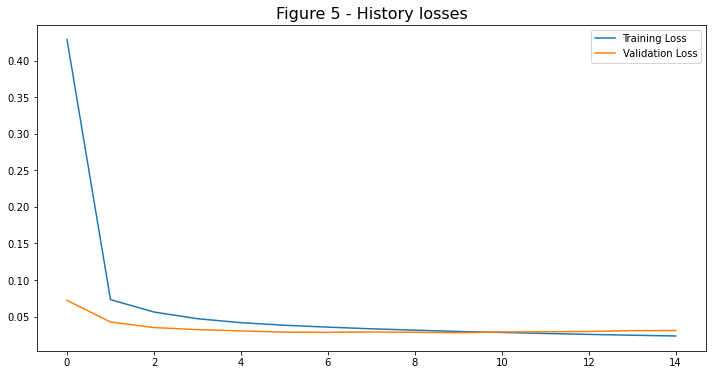

In [53]:
# Plot the loss history. 
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Figure 5 - History losses", size=16)
 
# Training loss history.
ax.plot(history.history["loss"], label="Training Loss")
# Validation loss history. 
ax.plot(history.history["val_loss"], label="Validation Loss")

ax.legend();

We can see in Figure 5, the loss on the y-axis and the attempts on the x-axis. This is suggesting that the valdation loss has a good training rate. And the training loss seems to be a bit higher but both losses appear to be working in a similar manner which indicates the model is working well.

<h3 style="color: #001a79;">Predict training values loss</h3>

Next step is to predict the training loss. This is done using the model predict method in keras. This fits into the model and perdicts the outcome of the data. 

In [54]:
# Predict training outcome.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 3s 18ms/step


Once the prediction has been made we now need to calculate the MSE loss. This is done by subtracting the window sequence from the trained prediction data and retrieving the mean. 

In [55]:
# Calculate the loss of predicted training outcome. 
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

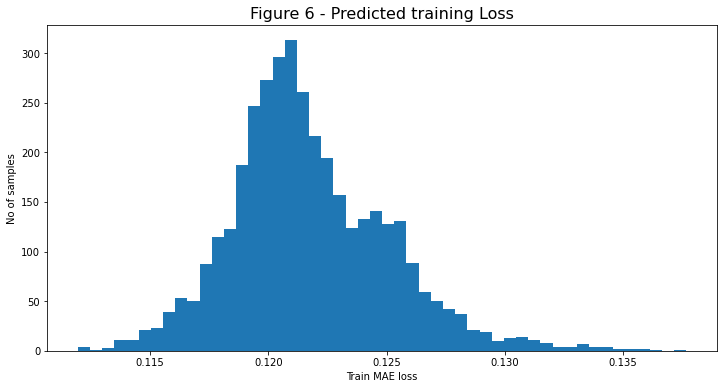

In [56]:
# Plot the predicted loss.  
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Figure 6 - Predicted training Loss", size=16)

# Histogram of predicted loss 
ax.hist(train_mae_loss, bins=50)
# Loss
ax.set_xlabel("Train MAE loss")
# Samples
ax.set_ylabel("No of samples");

In Figure 6 we can see the predicted training loss. This histogram is showing us that the model did pretty well. The loss isn't that much given the number of samples it processed. 


<h3 style="color: #001a79;">Get threshold</h3>

The idea of creating a threshold is so that the testing data loss can be compared to the maximum predicted training loss. This will in turn detect if an anomaly is present or not. 

In [57]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# Shows the maximun loss of the predicted outcome.
threshold

0.13767963617700335

<h3 style="color: #001a79;">Compare training vs prediction</h3>

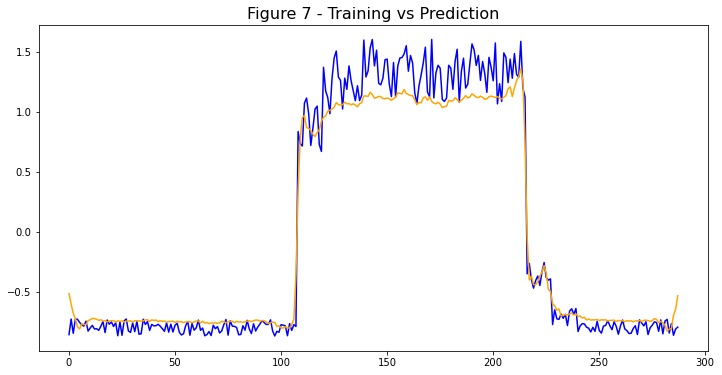

In [58]:
# PLotting training against what the neural network is predicting the output should be.
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Figure 7 - Training vs Prediction", size=16)

# Plot the first training value.
ax.plot(x_train[0], color="blue")
# Plot the first predicted outcome value.
ax.plot(x_train_pred[0], color="orange");

We can see from Figure 7 that the blue  line is displaying the first training values and the orange line is showing us the first predicted outcome. They seem pretty close that I am confident the training process is working well. The next step is to run the test data.

<h3 style="color: #001a79;">Set up testing data</h3>

We need to treat the testing data in the same manner we did with the training data. This means subtracting the mean and dividing by the standard deviation. Once this is done we can plot the the test values. 

In [59]:
# Apply same operation to test data. 
# Subtract mean and divide by std for test values. 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

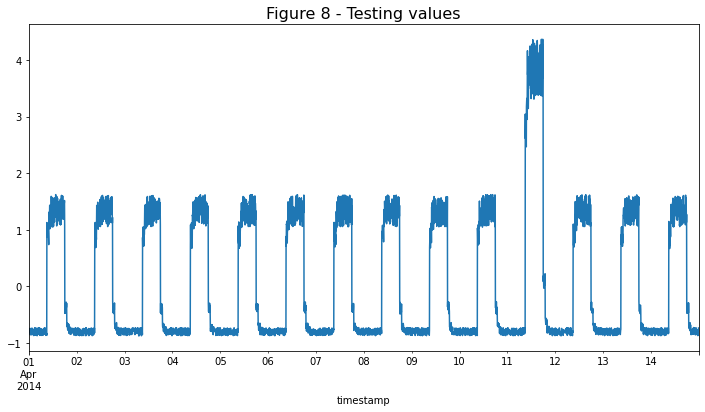

In [60]:
# Plot the test values. 
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Figure 8 - Testing values", size=16)

# Pass in the test values. 
df_test_value.plot(legend=False, ax=ax);

So we know the testing values should contain an anomaly. It looks like it does if you compare Figure 8 with the training values in Figure 3.

<h3 style="color: #001a79;">Create window sequence for testing values</h3>

Now we need to create the window sequence for the testing valeus in the exact same way we did for the training values. 

In [61]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

<h3 style="color: #001a79;">Predicting testing value loss</h3>

We will also create the predicted outcome and the loss of that outcome. 

In [62]:
# Predict the testing outcome. 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 2s 19ms/step


In [63]:
# Get the loss of predicted testing outcome
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.1173598 ],
       [0.12062581],
       [0.11846   ],
       ...,
       [0.12157534],
       [0.1220197 ],
       [0.12012975]])

In [64]:
# Reshape to make a row not a column
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.1173598 , 0.12062581, 0.11846   , ..., 0.12157534, 0.1220197 ,
       0.12012975])

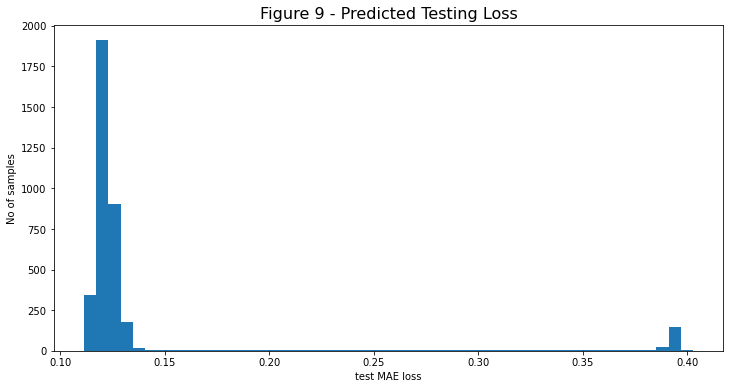

In [65]:
# Plot the predicted testing loss. 
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Figure 9 - Predicted Testing Loss", size=16)

# Testing loss.
ax.hist(test_mae_loss, bins=50)
# Loss.
ax.set_xlabel("test MAE loss")
# Samples.
ax.set_ylabel("No of samples");

Interesting that the testing loss seems a lot less that the training loss did. 

<h3 style="color: #001a79;">Detecting an anomaly</h3>

The final step now is to see if an anomaly has been detected. 

First step is to check if the predicted testing values loss is greater than the threshold which is the maximun loss of the predicted outcome. If this is true then there is an anomaly present. 

In [66]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

398

In [67]:
# Data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

# For each anomaly in the testing values
for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    # If all in the array are part of the anomalies list 
    if np.all(anomalies[i - window_size + 1 : i]):
        # Then add to the list
        inds.append(i)

What we have done here is looped through testing values, detected any anomalies and appended them to a list. This is done so we can get a subset of the testing values to show any anomalies. 

In [68]:
# Get subset of daily jumpsup if there are anomalies.
df_subset = df_daily_jumpsup.iloc[inds]

In [69]:
# descriptive analysis of the anomaly subset. 
df_subset.describe()

,value
count,108.000000
mean,146.349989
std,15.034190
min,44.913766
25%,139.862778
50%,149.224558
75%,156.604715
max,164.947481


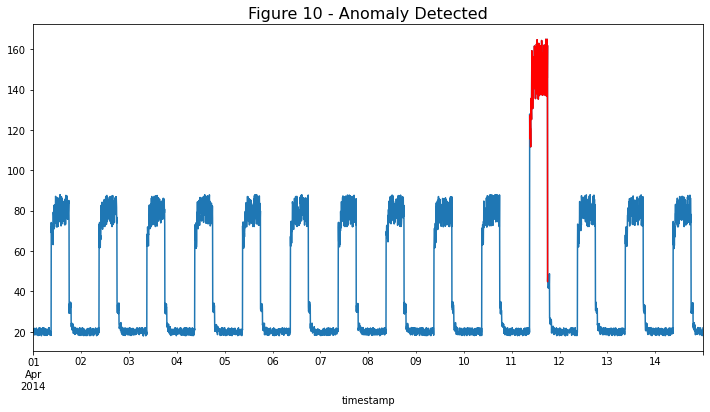

In [70]:
# Plot the subset on top of the testing values.
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Figure 10 - Anomaly Detected", size=16)

# Testing values.
df_daily_jumpsup.plot(legend=False, ax=ax)

# Subset of anomalies
df_subset.plot(legend=False, ax=ax, color="r");

We can see here in Figure 10 that an anomaly was detected within the testing dataset. This can be seen in red. 

<br>

The reason this was detected is because we have trained the training dataset values. Then we trained the model by giving the trained values as both the input and the output. This means that the model has been trained to give the same output as input. 

<br>

Therefore, when the model gets an input for an anomaly, the idea is that it should detect if there is a different output. And that output should be far enough away from the prediction that it raises a flag and is labelled an anomaly. This is what we are seeing in Figure 10. 

<br>

<h2 style="color: #001a79;">Conclusion</h2>

<hr style="border-top: 1px solid #001a79;" />

This notebook is an example of re-facturing code taken from the offical Keras documentation on timeseries anomaly detection. In other words, we took the code, adapted it, organised it and made it our own. And most importantly, and something which is missing from the official documentation, I provided step by step explainations on what is involved in a timeseries anomaly detection process. 

<br>

- The first step was loading the data. This meant taking the raw open source data for training and testing and passing it into pandas dataframes. These were analysed, manipulated and plotted.


- The next step was preprocessing. This involved setting up the training data. Then we had to train the model. This was done by creating a window sequence and passing the training data as both input and output values. 


- Next, the neural network was set up. This involved setting the layers for the foundation of the network. We also included loss for errors and then we fitted the model. This completed the training proccess for the model. 


- Finally, the evaluation process took place. This long operation started with accessing and plotting the training loss and validation loss history and plotting that data. This was done to see how well the model is working. Next, we predicted the loss of the training data. This prediction is used during the anomaly detection as the maximun predicted training loss is used as the threshold to determine if the testing input it too far away from the predicted loss. After that, we set up the testing data. This was done in the same mannor as the training data. The window sequence was created and the loss for the testing data was predicted. This prediction is very important because if this testing data loss prediction is greater than the threshold then a flag is raised detecting an anomaly. Finally, a loop is done through the testing data detecting any anomalies and these are passed to a new dataframe for plotting. 

<br>

This timeseries anomaly detection does in fact work. There are a lot of steps and it can be quite complex at times, however, by taking the code apart, reconstructing it and researching each element of it, I feel I have created a better understanding of how timeseries anomaly detection actually works. 

<hr style="border-top: 1px solid #001a79;" />

<h2 style="color: #001a79;">End</h2>